<a href="https://colab.research.google.com/github/keonju2/2022_GDSC_DL/blob/main/11%EC%A3%BC%EC%B0%A8_%EA%B3%B5%EC%9C%A0%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# random seed 설정
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)

In [ ]:
# 입력 문장
raw_inputs = [
    "나는 입학생 니다",
    "나는 좋은 선생님 입니다",
    "당신은 매우 좋은 선생님 입니다"
]

In [ ]:
# 정답: 명사(1), 기타(0)
raw_labels = [
    [0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1, 0]
]

In [ ]:
words = []

for s in raw_inputs:
  words.extend(s.split())
print(words)

['나는', '학생', '입니다', '나는', '좋은', '선생님', '입니다', '당신은', '매우', '좋은', '선생님', '입니다']


In [ ]:
words = list(dict.fromkeys(words))
print(words)

['나는', '학생', '입니다', '좋은', '선생님', '당신은', '매우']


In [ ]:
word_to_id = {"[PAD]":0,"[UNK]":1}

for w in words:
  word_to_id[w] =len(word_to_id)
print(word_to_id)

{'[PAD]': 0, '[UNK]': 1, '나는': 2, '학생': 3, '입니다': 4, '좋은': 5, '선생님': 6, '당신은': 7, '매우': 8}


In [ ]:
id_to_word = {i: w for w,i in word_to_id.items()}
print(id_to_word)

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '학생', 4: '입니다', 5: '좋은', 6: '선생님', 7: '당신은', 8: '매우'}


In [ ]:
inputs = []

for s in raw_inputs:
  inputs.append([word_to_id[w] for w in s.split()])

print(inputs)

[[2, 3, 4], [2, 5, 6, 4], [7, 8, 5, 6, 4]]


In [ ]:
labels = raw_labels

In [ ]:
class SimpleDataSet(torch.utils.data.Dataset):
    """ 데이터셋 클래스 """

    def __init__(self, inputs, labels):
        """
        생성자
        :param inputs: 입력
        :param labels: 정답
        """
        self.inputs  = inputs
        self.labels = labels
      

    def __len__(self):
        """ 데이터셋 길이 """

        return len(self.labels)

    def __getitem__(self, index):
        """
        데이터 한 개 조회
        :param index: 데이터 위치
        """
        return (torch.tensor(self.inputs[index]),
                torch.tensor(self.labels[index]))

    def collate_fn(self, batch):
        """
        batch단위로 데이터 처리
        :param batch: batch 단위 데이터
        """
        inputs, labels = list(zip(*batch))

        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True,padding_value=0)
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True,padding_value=0)

        batch =[inputs, labels]

        return batch

In [ ]:
# dataset
dataset = SimpleDataSet(inputs, labels)

print(len(dataset))

3


In [ ]:
sampler = torch.utils.data.RandomSampler(dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, sampler=sampler, collate_fn=dataset.collate_fn)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=2, sampler=None, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=2, sampler=None, collate_fn=dataset.collate_fn)

# Tutorial

In [ ]:
# model tutorial 입력
t_inputs = torch.tensor(inputs[:1])
t_labels = torch.tensor(labels[:1])

print(t_inputs, t_labels)

tensor([[2, 3, 4]]) tensor([[0, 1, 0]])


In [ ]:
# 단어 일련번호를 단어 벡터로 변환
embed = torch.nn.Embedding(len(word_to_id), 4)
hidden = embed(t_inputs)

print(hidden.shape, hidden)

torch.Size([1, 3, 4]) tensor([[[-0.2153,  0.8840, -0.7584, -0.3689],
         [-0.3424, -1.4020,  0.3206, -1.0219],
         [ 0.7988, -0.0923, -0.7049, -1.6024]]], grad_fn=<EmbeddingBackward0>)


In [ ]:
linear = torch.nn.Linear(4, 2)
logits = linear(hidden)

print(logits.shape, logits)

torch.Size([1, 3, 2]) tensor([[[-0.0855,  0.2240],
         [-0.2031,  0.7995],
         [-0.0121,  0.1328]]], grad_fn=<ViewBackward0>)


# Modeling and Prediction

In [ ]:
class SequencePrediction(torch.nn.Module):
    """ 단어단위 예측 모델 """

    def __init__(self, n_vocab):
        """
        생성자
        :param n_vocab: number of vocab
        """
        super().__init__()
        self.embed = torch.nn.Embedding(n_vocab,4)
        self.linear = torch.nn.Linear(4,2)


    def forward(self, inputs):
        """
        모델 실행
        :param inputs: input data
        """
        hidden = self.embed(inputs)
        logits = self.linear(hidden)

        return logits

In [ ]:
# 학습용 모델 생성
model = SequencePrediction(len(word_to_id))
model.to(device)

print(model)

SequencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
# loss & optimizer 생성
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [ ]:
def accuracy_fn(logits, labels):
    """
    model accuracy 측정
    :param logits: 예측 값
    :param labels: 정답
    """
    # 값이 최대인 index 값
    _, indices = logits.max(-1)
    # label과 비교
    matchs = torch.eq(indices, labels).cpu().numpy()
    total = np.ones_like(matchs)
    acc_val = np.sum(matchs) / max(1, np.sum(total))
    return acc_val

In [ ]:
def train_epoch(model, loader, loss_fn, optimizer):
    """
    1 epoch 학습
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    :param optimizer: optimizer
    """
    # model을 train 모드로 전환
    model.train()
    # loss 및 accuracy 저장
    losses, access = [], []
    # data loader에서 batch단위로 처리
    for batch in loader:
        # optimizer 초기화
        optimizer.zero_grad()
        # batch 입력값 처리 (CPU or GPU)
        inputs, labels = map(lambda v: v.to(device), batch)
        # 모델 실행
        logits = model(inputs)
        # loss 계산
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        # model weight 변경
        optimizer.step()
        # loss 저장
        loss_val = loss.item()
        losses.append(loss_val)
        # accuracy 계산 및 저장
        acc_val = accuracy_fn(logits, labels)
        access.append(acc_val)

    return np.mean(losses), np.mean(access)

In [ ]:
def eval_epoch(model, loader, loss_fn):
    """
    1 epoch 평가
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    """
    # model을 eval 모드로 전환
    model.eval()
    # loss 및 accuracy 저장
    losses, access = [], []
    # 실행시에 gradint 계산 비활성화
    with torch.no_grad():
        for batch in loader:
            # batch 입력값 처리 (CPU or GPU)
            inputs, labels = map(lambda v: v.to(device), batch)
            # 모델 실행
            logits = model(inputs)
            # loss 계산
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # loss 저장
            loss_val = loss.item()
            losses.append(loss_val)
            # accuracy 계산 및 저장
            acc_val = accuracy_fn(logits, labels)
            access.append(acc_val)

    return np.mean(losses), np.mean(access)

In [ ]:
# 학습 history
history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
# 가장 좋은 acc 값
best_acc = 0

In [ ]:
path='predicts.pth' # 저장경로

In [ ]:
# 학습 및 평가
for e in range(200):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    valid_loss, valid_acc = eval_epoch(model, valid_loader, loss_fn)
    # 학습 history 저장
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    # 학습과정 출력
    print(f"eopch: {e + 1:3d}, train_loss: {train_loss:.5f}, train_acc: {train_acc: .5f}, valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc:.5f}")
    # best weight 저장
    if best_acc < valid_acc:
        best_acc = valid_acc
        # 저장
        torch.save(
            {"state_dict": model.state_dict(), "valid_acc": valid_acc},path
        )
        # 저장내용 출력
        print(f"  >> save weights{path}")

eopch:   1, train_loss: 0.47438, train_acc:  0.77500, valid_loss: 0.46834, valid_acc: 0.77500
  >> save weightspredicts.pth
eopch:   2, train_loss: 0.53751, train_acc:  0.73333, valid_loss: 0.46130, valid_acc: 0.77500
eopch:   3, train_loss: 0.45972, train_acc:  0.77500, valid_loss: 0.45488, valid_acc: 0.77500
eopch:   4, train_loss: 0.45727, train_acc:  0.77500, valid_loss: 0.44810, valid_acc: 0.77500
eopch:   5, train_loss: 0.45004, train_acc:  0.77500, valid_loss: 0.44114, valid_acc: 0.77500
eopch:   6, train_loss: 0.51540, train_acc:  0.73333, valid_loss: 0.43443, valid_acc: 0.77500
eopch:   7, train_loss: 0.43582, train_acc:  0.77500, valid_loss: 0.42806, valid_acc: 0.77500
eopch:   8, train_loss: 0.42905, train_acc:  0.77500, valid_loss: 0.42158, valid_acc: 0.77500
eopch:   9, train_loss: 0.49932, train_acc:  0.73333, valid_loss: 0.41525, valid_acc: 0.77500
eopch:  10, train_loss: 0.49388, train_acc:  0.73333, valid_loss: 0.40943, valid_acc: 0.77500
eopch:  11, train_loss: 0.4885

In [ ]:
def draw_history(history):
    """
    학습과정 그래프 출력
    :param history: 학습 이력
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], "b-", label="train_loss")
    plt.plot(history["valid_loss"], "r--", label="valid_loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], "k--", label="train_acc")
    plt.plot(history["valid_acc"], "r--", label="valid_acc")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

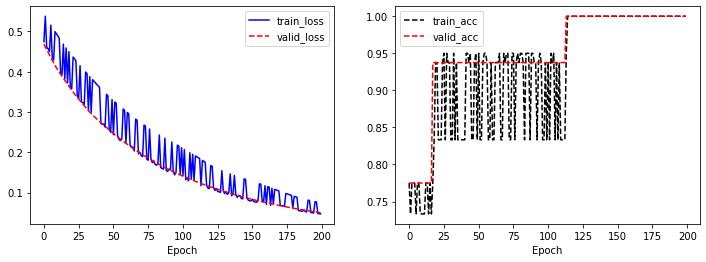

In [ ]:
draw_history(history)

In [ ]:
# 테스트용 모델 생성
model = SequencePrediction(len(word_to_id))
model.to(device)

print(model)

SequencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
# 저장된 데이터 로드
save_dict = torch.load(path)

print(save_dict)

{'state_dict': OrderedDict([('embed.weight', tensor([[-0.6761, -0.0923,  1.2408,  0.8631],
        [ 0.1825, -0.0737,  0.3147, -1.0369],
        [ 1.4363,  0.6763,  0.4039, -0.4247],
        [-2.1219,  0.6028,  0.4720, -0.0487],
        [ 0.6925,  0.9276,  0.5715, -0.7990],
        [ 0.1702,  0.0428,  1.6407,  1.5097],
        [-1.4068, -0.5916, -1.7387, -2.5789],
        [-1.3098,  1.5172,  0.9090,  0.0119],
        [ 0.2526,  1.1006,  1.7099,  1.1954]], device='cuda:0')), ('linear.weight', tensor([[ 0.7735,  0.5543,  0.1758,  0.0710],
        [-0.0578, -0.1202, -0.6983, -0.0582]], device='cuda:0')), ('linear.bias', tensor([ 0.5076, -0.4252], device='cuda:0'))]), 'valid_acc': 1.0}


In [ ]:
model.load_state_dict(save_dict['state_dict'])
# 학습된 weights로 초기화 모델 평가
valid_loss, valid_acc = eval_epoch(model, test_loader, loss_fn)

print(valid_loss, valid_acc)

0.1227789968252182 1.0
